In [488]:
%matplotlib inline

In [489]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset
import os
import pandas as pd
from skimage import io
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [490]:
"""
import zipfile

!wget --no-check-certificate \
  https://github.com/IlicStefan/ChessDiagramRecognition/archive/refs/heads/master.zip \
  -O "/tmp/chess_pieces.zip"
zip_ref = zipfile.ZipFile('/tmp/chess_pieces.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()
"""

'\nimport zipfile\n\n!wget --no-check-certificate   https://github.com/IlicStefan/ChessDiagramRecognition/archive/refs/heads/master.zip   -O "/tmp/chess_pieces.zip"\nzip_ref = zipfile.ZipFile(\'/tmp/chess_pieces.zip\', \'r\') #Opens the zip file in read mode\nzip_ref.extractall(\'/tmp\') #Extracts the files into the /tmp folder\nzip_ref.close()\n'

In [491]:
black_square = {"empty" : 0,
                  "black_pawn" : 1,
                  "black_rook" : 2,
                  "black_knight" : 3,
                  "black_bishop" : 4,
                  "black_queen" : 5,
                  "black_king" : 6,
                  "white_pawn" : 7,
                  "white_rook" : 8,
                  "white_knight" : 9,
                  "white_bishop" : 10,
                  "white_queen" : 11,
                  "white_king" : 12}
white_square = {"empty" : 13,
                  "black_pawn" : 14,
                  "black_rook" : 15,
                  "black_knight" : 16,
                  "black_bishop" : 17,
                  "black_queen" : 18,
                  "black_king" : 19,
                  "white_pawn" : 20,
                  "white_rook" : 21,
                  "white_knight" : 22,
                  "white_bishop" : 23,
                  "white_queen" : 24,
                  "white_king" : 25}
                  
def create_csv(root_dir):
  data = {}
  for subdir, dirs, files in os.walk(root_dir):
    for file in files:
      filepath = subdir + os.sep + file
      if file.endswith(".jpg"):
        path = filepath.split("/")
        if ("black_square" in filepath):
          data[filepath] = black_square[path[6]]
        elif ("white_square" in filepath):
          data[filepath] = white_square[path[6]]
  print(data)
  df = pd.DataFrame.from_dict(data, orient='index')
  df.to_csv(path_or_buf='/tmp/chess_pieces.csv')

    

In [492]:
create_csv('/tmp/ChessDiagramRecognition-master/datasets/squares')

{'/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square1545.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square1803.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square5064.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square4039.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square4935.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square1232.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square4813.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square5763.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square4170.jpg': 4, '/tmp/ChessDiagramRecognition-master/datasets/squares/black_square/black_bishop/square841.jpg': 4, 

In [493]:
from PIL import Image
class ChessPieces(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
      return len(self.annotations)

  def __getitem__(self, index):
      img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
      image = Image.open(img_path)
      image = image.convert("L")
      y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

      if self.transform:
        image = self.transform(image)

      return (image, y_label)

In [494]:
def get_piece_data():
  dataset = ChessPieces('/tmp/chess_pieces.csv', root_dir="",
                        transform=transforms.ToTensor())
  trainset, testset = torch.utils.data.random_split(dataset, [5600, 800])

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                           num_workers=2)
  classes = range(25)
  return {"train": trainloader, "test": testloader, "classes": classes}
data = get_piece_data()
print(data['train'].__dict__)
  
  

{'dataset': <torch.utils.data.dataset.Subset object at 0x7f358b6d66d0>, 'num_workers': 2, 'prefetch_factor': 2, 'pin_memory': False, 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 32, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7f358b6d6650>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7f358b6d6410>, 'generator': None, 'collate_fn': <function default_collate at 0x7f35a7ab4d40>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [495]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 32, 32])


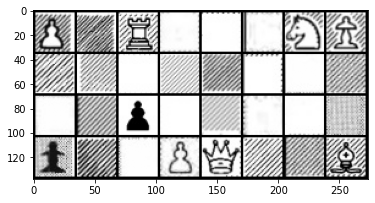

Labels:        7         0         8        13        13        13         9         7
torch.Size([32, 1, 32, 32])
torch.Size([32, 1024])


In [496]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % data['classes'][labels[j]] for j in range(8)))


flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())


In [497]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=1024, hidden=512, outputs=26):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)
        """
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 256)
        self.fc4 = nn.Linear(256, outputs)
        """

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)  # activaction function: 92.4% -> 98.6% accuracy
        x = self.fc2(x)
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        """
        # No softmax, happens in loss function
        return x


In [498]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.01, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

In [499]:

net = SimpleNet()

losses = train(net, data['train'], epochs=25)

print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())


plt.plot(losses)


[1,   100] loss: 1.607
[2,   100] loss: 0.823
[3,   100] loss: 0.515
[4,   100] loss: 0.406
[5,   100] loss: 0.375


KeyboardInterrupt: ignored

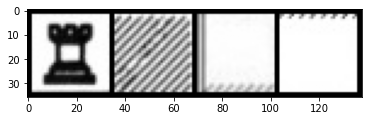

GroundTruth:     21     0    13    13
Predicted:     15     0    13    13


In [500]:
dataiter = iter(data['test'])
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

In [501]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

[1,   100] loss: 1.577
[2,   100] loss: 0.777
[3,   100] loss: 0.542
[4,   100] loss: 0.471
[5,   100] loss: 0.391
[6,   100] loss: 0.366
[7,   100] loss: 0.335
[8,   100] loss: 0.325
[9,   100] loss: 0.305
[10,   100] loss: 0.307
[11,   100] loss: 0.291
[12,   100] loss: 0.295
[13,   100] loss: 0.345
[14,   100] loss: 0.364
[15,   100] loss: 0.284
[16,   100] loss: 0.299
[17,   100] loss: 0.280
[18,   100] loss: 0.349
[19,   100] loss: 0.326
[20,   100] loss: 0.370
[21,   100] loss: 0.278
[22,   100] loss: 0.279
[23,   100] loss: 0.320
[24,   100] loss: 0.283
[25,   100] loss: 0.278
OrderedDict([('fc1.weight', tensor([[ 3.3673e-04, -2.4605e-04, -1.0822e-04,  ..., -1.5729e-05,
          1.1042e-05, -3.6791e-04],
        [ 3.5787e-04,  5.3235e-06,  3.0058e-04,  ...,  6.1760e-05,
          3.6494e-05, -1.6933e-04],
        [ 3.2379e-04,  2.4094e-04,  1.2652e-04,  ...,  1.2132e-04,
         -1.8401e-04,  2.9565e-04],
        ...,
        [ 9.4839e-03,  1.4627e-02,  1.0506e-02,  ...,  1.71

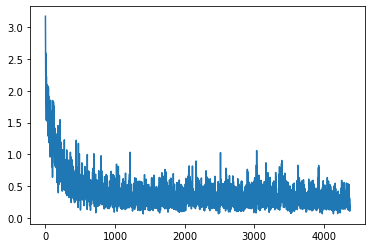

In [502]:
net1 = SimpleNet()

losses1 = train(net1, data['train'], epochs=25)
#torch.save(net1.state_dict(), "/tmp/SimpleNet1.pth")
#print(net1.state_dict())
plt.plot(losses1)
print("Current training accuracy: %f" % accuracy(net1, data['train']))
print("Current testing  accuracy: %f" % accuracy(net1, data['test']))

In [507]:
eval_pieces = {
    0: "e",
    1: "p",
    2: "r",
    3: "n",
    4: "b",
    5: "q",
    6: "k",
    7: "P",
    8: "R",
    9: "N",
    10: "B",
    11: "Q",
    12: "K",
}
class DiagramProcessor:
  def __init__(self, diagram_path):
    self.model = SimpleNet()
    self.model.load_state_dict(torch.load("/tmp/SimpleNet1.pth"))
    self.model.eval()
    self.diagram = Image.open(diagram_path)
    self.diagram = self.diagram.convert("L")
    self.diagram = self.diagram.resize((256, 256))
    self.FEN = []
    self.evals = []

  def process(self):
    squares = []
    h_step = round(self.diagram.height / 8)
    w_step = round(self.diagram.width / 8)
    array = np.asarray(self.diagram)
    for i in range(8):
      for j in range(8):
        a = i*h_step
        b = (i+1)*h_step
        c = j*w_step
        d = (j+1)*w_step
        squares.append(array[a:b,c:d])
    for square in squares:
      newsq = square[0:32,0:32]
      newsq = torchvision.transforms.functional.to_tensor(newsq)
      y_prob = self.model(newsq)
      y_classes = y_prob.argmax(axis=-1)
      y_classes = y_classes.item()
      self.evals.append(y_classes)
    
  def write_evals(self):
    return self.evals

  def writeFEN(self):
    for eval in self.evals:
      self.FEN.append(eval_pieces[eval % 13])
    empty = 0
    count = 0
    string = ""
    for letter in self.FEN:
      if count is 8:
        if empty > 0:
          string += str(empty)
        string += "/"
        empty = 0
        count = 0
      if letter is "e":
        empty = empty + 1
        if empty is 8:
          string += str(8)
          empty = 0
        count += 1
      else:
        if empty > 0:
          string += str(empty)
          string += letter
          empty = 0
          count += 1
        else:
          string += letter
          count += 1
    if empty > 0:
      string += str(empty)
    string += " w - - 0 1"
    return string


In [505]:
def image_selector(root_dir):
  images = []
  for subdir, dirs, files in os.walk(root_dir):
    for file in files:
      if file.endswith(".jpg"):
        image = Image.open(root_dir + file)
        images.append(file)
  return images


In [508]:
for file in image_selector("/tmp/ChessDiagramRecognition-master/datasets/diagrams/"):
  dp = DiagramProcessor("/tmp/ChessDiagramRecognition-master/datasets/diagrams/" + file)
  dp.process()
  print(file)
  print(dp.writeFEN())

d51.jpg
3q4/4Pppk/1bp3p1/4p1n1/2B1P2p/P4P1P/PP2PPP1/8 w - - 0 1
d27.jpg
1r1q1rk1/p4ppp/b2b4/n1p5/4Q3/1PP2N2/P5R1/RNB3R1 w - - 0 1
d86.jpg
r2qrbk1/pb1n1p1p/1p1ppnp1/8/N1PP1B2/P2B1N1P/1P3PP1/2RqR1K1 w - - 0 1
d77.jpg
2r3k1/Pq3p1p/p2qp1pP/6P1/2P2P1P/5PP1/P3P1pP/3R4 w - - 0 1
d14.jpg
r2q1rk1/1pp1b1pp/4bp2/pP1np3/3n4/P1NP2P1/3PPPB1/1RBR1RB1 w - - 0 1
d30.jpg
2r3k1/1q2ppbp/p5p1/1p1P4/4P3/3Q3P/P2B1PP1/2P3P1 w - - 0 1
d35.jpg
3r4/1q3pk1/1r3bp1/p6p/1P2RP2/P1p3PP/2Q2P2/1R4P1 w - - 0 1
d79.jpg
1kr5/pprbn1p1/q4p2/P1pPp1np/2P1P3/P1PB3P/1R2N1P1/1R4B1 w - - 0 1
d60.jpg
r7/pp3qkp/4rp2/n2p4/P1pP3P/B1P5/5RPP/5RK1 w - - 0 1
d74.jpg
5rk1/3b1pbp/5np1/2QP4/6P1/1B2P1NP/3q4/1R3P1R w - - 0 1
d71.jpg
5q2/P2k4/5P1P/p3P1P1/1p5P/PqP1P1P1/5PK1/8 w - - 0 1
d87.jpg
r1b1k1nr/pp3ppp/2n5/bN1qp3/8/5N2/2PP1PPP/R1BQPB1R w - - 0 1
d29.jpg
r2qr1k1/3b1ppp/pb1p1n2/1p1Pn3/2p1PP2/PPN3PP/3BB1P1/3Q1R1R w - - 0 1
d67.jpg
5rk1/Pp1qp1bp/p2p2p1/4n3/P1P1P3/1PP2rP1/3B1PKP/8 w - - 0 1
d98.jpg
2r2rk1/pp4pp/1q2p1p1/2bpPn2/b7/1NP2NB1/PPQ1RP